# Knowledge Graph Generation from Historical Letters

This notebook processes the historical letter (JP_I_4.md) using an LLM to identify themes and ideas, then exports the results to TTL (Turtle) format for knowledge graph construction.

## 1. Install Required Dependencies

In [1]:
# Install required packages
%pip install openai rdflib python-dotenv

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## 2. Import Libraries and Load the Letter

In [2]:
# model choice:
text = "" # write here the model you want to use.

In [3]:
text

'llama'

In [3]:
import os
import json
from openai import OpenAI
from rdflib import Graph, Namespace, Literal, URIRef
from rdflib.namespace import RDF, RDFS, FOAF, DCTERMS
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Read the letter
with open('JP_I_4.md', 'r', encoding='utf-8') as f:
    letter_text = f.read()

print("Letter loaded successfully!")
print(f"Letter length: {len(letter_text)} characters")

Letter loaded successfully!
Letter length: 2417 characters


## 3. Configure LLM (OpenAI or OpenRouter)

**Note:** You'll need to set your API key in a `.env` file or as an environment variable.

For **OpenAI**:
```
OPENAI_API_KEY=your-api-key-here
```

For **OpenRouter**:
```
OPENROUTER_API_KEY=your-api-key-here
```

In [4]:
#read api from jsn
with open('openai_api.json', 'r') as f:
    api_data = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'openai_api.json'

In [11]:
# Initialize OpenAI client (works with OpenRouter too)
# Check if using OpenRouter or OpenAI
openrouter_key = os.getenv('OPENROUTER_API_KEY')
openai_key = os.getenv('OPENAI_API_KEY')

if openrouter_key:
    # Use OpenRouter
    client = OpenAI(
        api_key=openrouter_key,
        base_url="https://openrouter.ai/api/v1"
    )
    
    # ==================================================================
    # RELIABLE FREE MODELS (tested and available as of Jan 2026)
    # ==================================================================
    # "meta-llama/llama-3.2-3b-instruct:free"     - RECOMMENDED: Good balance
    # "meta-llama/llama-3.2-1b-instruct:free"     - Faster, smaller
    # "google/gemini-2.0-flash-exp:free"          - Google experimental
    # ==================================================================
    
    # Default to most reliable free model
    model = "meta-llama/llama-3.2-3b-instruct:free"
    max_tokens = 1000  # Adjust based on your needs
    print("Using OpenRouter API")
    print(f"Selected model: {model}")
elif openai_key:
    # Use OpenAI
    client = OpenAI(api_key=openai_key)
    model = "gpt-3.5-turbo"  # More affordable than GPT-4
    max_tokens = 2000
    print("Using OpenAI API")
else:
    raise ValueError("Please set either OPENROUTER_API_KEY or OPENAI_API_KEY in your .env file")

# Define the prompt for theme extraction
prompt = f"""Analyze the following historical letter and extract themes, ideas, and key information. 

Letter:
{letter_text}

Please identify and structure the following information in JSON format:
1. Main themes (e.g., financial hardship, education, family, patronage)
2. Key ideas or topics discussed
3. Named entities (people, places, institutions)
4. Relationships between entities
5. Time references
6. Emotions or sentiments expressed

Return a JSON object with this structure:
{{
    "themes": [list of theme strings],
    "ideas": [list of idea/topic strings],
    "entities": {{
        "people": [list of person names],
        "places": [list of places],
        "institutions": [list of institutions/organizations]
    }},
    "relationships": [
        {{"source": "entity1", "relation": "relationship_type", "target": "entity2"}}
    ],
    "temporal_references": [list of time/date references],
    "sentiments": [list of emotions or sentiments]
}}
"""

print(f"Using model: {model}")
print(f"Max tokens: {max_tokens}")
print("Prompt prepared. Ready to call LLM.")

Using OpenRouter API
Using model: mistralai/mistral-7b-instruct:free
Max tokens: 1000
Prompt prepared. Ready to call LLM.


## 4. Process Letter with LLM

In [12]:
# Call the LLM
response = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": "You are an expert in analyzing historical documents and extracting structured information for knowledge graphs. Return ONLY valid JSON, nothing else."},
        {"role": "user", "content": prompt}
    ],
    max_tokens=max_tokens,
    temperature=0.3
)

# Get the response content
content = response.choices[0].message.content
print("="*60)
print("RAW LLM RESPONSE:")
print("="*60)
print(content)
print("="*60 + "\n")

# Try to extract JSON from the response
analysis = None
parsing_method = None

try:
    # First try direct parsing
    analysis = json.loads(content)
    parsing_method = "Direct JSON parsing"
except json.JSONDecodeError as e:
    print(f"⚠️ Direct JSON parsing failed: {e}\n")
    
    # Try to extract JSON from markdown code blocks
    import re
    code_block_match = re.search(r'```(?:json)?\s*(\{.*\})\s*```', content, re.DOTALL)
    if code_block_match:
        try:
            analysis = json.loads(code_block_match.group(1))
            parsing_method = "Extracted from markdown code block"
        except json.JSONDecodeError:
            pass
    
    # If that fails, try to find JSON anywhere in the response
    if analysis is None:
        json_match = re.search(r'\{.*\}', content, re.DOTALL)
        if json_match:
            try:
                analysis = json.loads(json_match.group())
                parsing_method = "Extracted JSON from text"
            except json.JSONDecodeError as e2:
                print(f"⚠️ JSON extraction failed: {e2}\n")

# If we still don't have valid analysis, fail clearly
if analysis is None:
    print("❌ ERROR: Could not extract valid JSON from LLM response.")
    print("The model did not return properly formatted data.")
    print("\nYou have two options:")
    print("1. Try a different model (edit the 'model' variable in cell 7)")
    print("2. Add credits to OpenRouter or use OpenAI")
    print("3. Manually create the analysis structure based on the text above")
    raise ValueError("LLM did not return valid JSON. Cannot proceed with knowledge graph generation.")

print(f"✓ JSON parsing successful using: {parsing_method}\n")
print("="*60)
print("PARSED ANALYSIS STRUCTURE:")
print("="*60)
print(json.dumps(analysis, indent=2))
print("="*60)

NotFoundError: Error code: 404 - {'error': {'message': 'No endpoints found for mistralai/mistral-7b-instruct:free.', 'code': 404}, 'user_id': 'user_36stG8cK2wOlIkIjtjjW9bmpB51'}

## 5. Build Knowledge Graph in RDF

In [22]:
# Create RDF graph
g = Graph()

# Define namespaces
EX = Namespace("http://example.org/letters/")
LETTER = Namespace("http://example.org/letters/ontology#")
SCHEMA = Namespace("http://schema.org/")

g.bind("ex", EX)
g.bind("letter", LETTER)
g.bind("schema", SCHEMA)
g.bind("foaf", FOAF)
g.bind("dcterms", DCTERMS)

# Create the letter resource
letter_uri = EX["JP_I_4"]
g.add((letter_uri, RDF.type, LETTER.Letter))
g.add((letter_uri, DCTERMS.title, Literal("Von Jean Paul an Johann Ruß. Schwarzenbach a. d. Saale, April 1781")))
g.add((letter_uri, DCTERMS.date, Literal("1781-04")))
 
# Add themes
for theme in analysis.get('themes', []):
    theme_uri = EX[theme.replace(" ", "_")]
    g.add((theme_uri, RDF.type, LETTER.Theme))
    g.add((theme_uri, RDFS.label, Literal(theme)))
    g.add((letter_uri, LETTER.hasTheme, theme_uri))

# Add ideas
for idea in analysis.get('ideas', []):
    idea_uri = EX[idea.replace(" ", "_").replace(",", "")]
    g.add((idea_uri, RDF.type, LETTER.Idea))
    g.add((idea_uri, RDFS.label, Literal(idea)))
    g.add((letter_uri, LETTER.discusses, idea_uri))

# Add entities - people
for person in analysis.get('entities', {}).get('people', []):
    person_uri = EX[person.replace(" ", "_")]
    g.add((person_uri, RDF.type, FOAF.Person))
    g.add((person_uri, FOAF.name, Literal(person)))
    g.add((letter_uri, LETTER.mentionsPerson, person_uri))

# Add entities - places
for place in analysis.get('entities', {}).get('places', []):
    place_uri = EX[place.replace(" ", "_").replace(".", "")]
    g.add((place_uri, RDF.type, SCHEMA.Place))
    g.add((place_uri, SCHEMA.name, Literal(place)))
    g.add((letter_uri, LETTER.mentionsPlace, place_uri))

# Add entities - institutions
for institution in analysis.get('entities', {}).get('institutions', []):
    inst_uri = EX[institution.replace(" ", "_")]
    g.add((inst_uri, RDF.type, SCHEMA.Organization))
    g.add((inst_uri, SCHEMA.name, Literal(institution)))
    g.add((letter_uri, LETTER.mentionsInstitution, inst_uri))

# Add relationships
for rel in analysis.get('relationships', []):
    source_uri = EX[rel['source'].replace(" ", "_")]
    target_uri = EX[rel['target'].replace(" ", "_")]
    relation_type = LETTER[rel['relation'].replace(" ", "_")]
    g.add((source_uri, relation_type, target_uri))

# Add sentiments
for sentiment in analysis.get('sentiments', []):
    sentiment_uri = EX[sentiment.replace(" ", "_")]
    g.add((sentiment_uri, RDF.type, LETTER.Sentiment))
    g.add((sentiment_uri, RDFS.label, Literal(sentiment)))
    g.add((letter_uri, LETTER.hasSentiment, sentiment_uri))

print(f"Knowledge graph created with {len(g)} triples!")

Knowledge graph created with 60 triples!


## 6. Export to TTL Format

In [23]:
# Serialize to TTL format
ttl_output = g.serialize(format='turtle')

# Save to file
output_filename = 'JP_I_4_knowledge_graph.ttl'
with open(output_filename, 'w', encoding='utf-8') as f:
    f.write(ttl_output)

print(f"Knowledge graph saved to {output_filename}")
print("\nFirst 50 lines of TTL output:")
print('\n'.join(ttl_output.split('\n')[:50]))

Knowledge graph saved to JP_I_4_knowledge_graph.ttl

First 50 lines of TTL output:
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix ex: <http://example.org/letters/> .
@prefix foaf: <http://xmlns.com/foaf/0.1/> .
@prefix letter: <http://example.org/letters/ontology#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix schema1: <http://schema.org/> .

ex:JP_I_4 a letter:Letter ;
    letter:discusses ex:application_for_university_education,
        ex:importance_of_family_connections_for_success,
        ex:importance_of_personal_connections_for_success,
        ex:request_for_financial_assistance ;
    letter:hasSentiment ex:desperate,
        ex:grateful,
        ex:hopeful ;
    letter:hasTheme ex:education,
        ex:family,
        ex:financial_hardship,
        ex:patronage ;
    letter:mentionsInstitution ex:University_of_Leipzig ;
    letter:mentionsPerson ex:Esper,
        ex:Jean_Paul,
        ex:Johann_Ruß ;
    letter:mentionsPlace ex:Leipzig,
        ex:

## 7. Visualize Graph Statistics

In [24]:
# Print statistics
print("=== Knowledge Graph Statistics ===")
print(f"Total triples: {len(g)}")
print(f"\nThemes: {len(analysis.get('themes', []))}")
print(f"Ideas: {len(analysis.get('ideas', []))}")
print(f"People mentioned: {len(analysis.get('entities', {}).get('people', []))}")
print(f"Places mentioned: {len(analysis.get('entities', {}).get('places', []))}")
print(f"Institutions mentioned: {len(analysis.get('entities', {}).get('institutions', []))}")
print(f"Relationships: {len(analysis.get('relationships', []))}")
print(f"Sentiments: {len(analysis.get('sentiments', []))}")

print("\n=== Extracted Information ===")
print(f"\nThemes: {', '.join(analysis.get('themes', []))}")
print(f"\nPeople: {', '.join(analysis.get('entities', {}).get('people', []))}")
print(f"\nPlaces: {', '.join(analysis.get('entities', {}).get('places', []))}")

=== Knowledge Graph Statistics ===
Total triples: 60

Themes: 4
Ideas: 4
People mentioned: 3
Places mentioned: 3
Institutions mentioned: 1
Relationships: 3
Sentiments: 3

=== Extracted Information ===

Themes: financial hardship, education, family, patronage

People: Jean Paul, Johann Ruß, Esper

Places: Schwarzenbach a. d. Saale, Leipzig, Wonsiedel


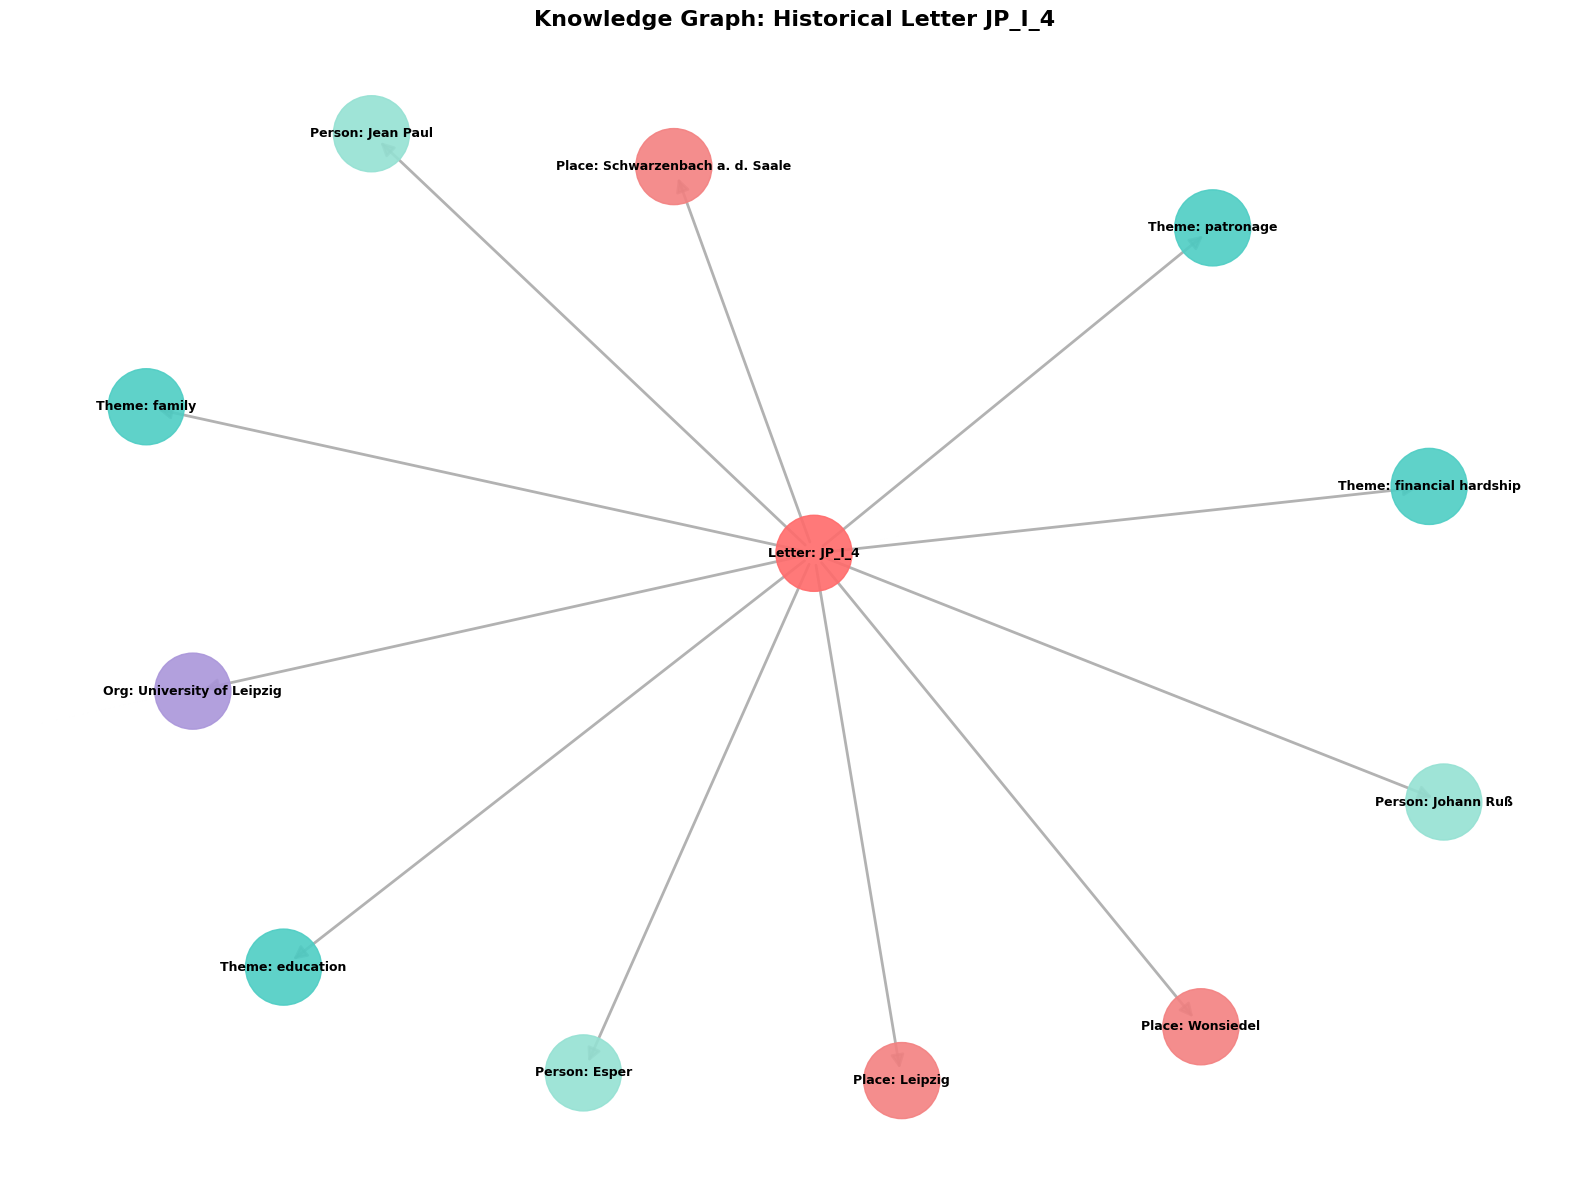

Graph has 12 nodes and 11 edges
Visualization saved as 'knowledge_graph_visualization.png'


In [26]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add letter node
G.add_node("Letter: JP_I_4", node_type="letter", color="#FF6B6B")

# Add themes
for theme in analysis.get('themes', []):
    node_name = f"Theme: {theme}"
    G.add_node(node_name, node_type="theme", color="#4ECDC4")
    G.add_edge("Letter: JP_I_4", node_name)

# Add people
for person in analysis.get('entities', {}).get('people', []):
    node_name = f"Person: {person}"
    G.add_node(node_name, node_type="person", color="#95E1D3")
    G.add_edge("Letter: JP_I_4", node_name, label="mentions")

# Add places
for place in analysis.get('entities', {}).get('places', []):
    node_name = f"Place: {place}"
    G.add_node(node_name, node_type="place", color="#F38181")
    G.add_edge("Letter: JP_I_4", node_name, label="mentions")

# Add institutions
for institution in analysis.get('entities', {}).get('institutions', []):
    node_name = f"Org: {institution}"
    G.add_node(node_name, node_type="institution", color="#AA96DA")
    G.add_edge("Letter: JP_I_4", node_name, label="mentions")

# Create visualization
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

# Get colors for nodes
node_colors = [G.nodes[node].get('color', '#CCCCCC') for node in G.nodes()]

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=3000, alpha=0.9)
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, 
                       arrowsize=20, width=2, alpha=0.6)

plt.title("Knowledge Graph: Historical Letter JP_I_4", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.savefig('knowledge_graph_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
print("Visualization saved as 'knowledge_graph_visualization.png'")

In [19]:
%pip install networkx matplotlib

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.6 MB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 2.7 MB/s eta 0:00:01
     |▌                               | 122 kB 3.7 MB/s eta 0:00:03  Downloading matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl (7.8 MB)
     |████████████████████████████████| 7.8 MB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 7.8 MB 3.1 MB/s 
     |█▎                              | 10 kB 3.3 MB/s eta 0:00:01Collecting contourpy>=1.0.1
     |████████████████████████████████| 249 kB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 249 kB 3.2 MB/s eta 0:00:01
     |▌                               | 40 kB 3.3 MB/s eta 0:00:01Collecting fonttools>=4.22.0
     |████████████████████████████████| 2.9 MB 3.7 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 3.7 MB/s 
  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl (5.3 MB)
  Us

## 8. Visualize the Knowledge Graph